# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__ *liste des points auxquels on cherche à répondre*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from math import exp, log
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

In [31]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','RESPID','UCPSID','SEX','UAGE','SITE','STATE','UREGION','TYPEINT','HHID']
household_id_hh = ['HHID']
#education = ['CCHGSC','CSUEXP','CATTSC','CSKIPSC','CGETBY','CHMWK','CINTSC','CWRKSC','UENG','UENGNEG','UENGPOS']
education = ['UENG','UENGNEG','UENGPOS']
#family = ['GHMAD','GSELFHR','UFAMSTR','UMH2','UMHIGDEG']
family = ['GSELFHR','UFAMSTR','UMH2','UMHIGDEG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT'] #'OVERCROWDING' added later on
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS']
health = ['BDISBL','BHLTHN','FDOCT','FWHMED','FWHYMED','FDENT','FWELLV','UCNGHL']
activities = ['NOUTING','NSPORTS','UOUTNEG','UOUTPOS','UACT','UACTNEG','UACTPOS']
programs = ['GCENTR','CSPECED','GHEADS','KAPPMED','SSHELP']
programs_hh = ['MPUBHOUS']

In [4]:
# Add a variable 'overcrowding' and replace inf by -1
hh['OVERCROWDING'] = hh['UHHCOUNT'] / hh['MNBEDRMS']
housing_hh.append('OVERCROWDING')
hh['OVERCROWDING'] = hh['OVERCROWDING'].apply(lambda x : -1 if x == np.inf else x)

In [5]:
# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + programs]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh + programs_hh]


In [6]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')
# replace all the missing values by the str 'no data', No by 0 and Yes by 1
child.replace([-7,-8,-9],-1,inplace=True) 

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,KAPPMED,SSHELP,CHLD0_5,CHLD6_17,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,MPUBHOUS
0,5561612801,1,5561612803,5561612800,F,3,15,WI,2,A1,...,-1,-1,2,0,3,1,4,1,0.75,-1
1,5470400001,2,5470400003,5470400000,M,14,15,WI,2,A1,...,1,-1,0,2,3,2,2,2,1.50,-1
2,5787427204,2,5787427205,5787427200,F,9,15,WI,2,A1,...,-1,-1,0,4,6,1,3,2,2.00,2
3,5410681601,1,5410681604,5410681600,M,4,15,WI,2,A1,...,-1,-1,3,0,5,1,2,2,2.50,2
4,5051721601,2,5051721605,5051721600,F,17,15,WI,2,A1,...,-1,-1,0,4,5,1,4,2,1.25,1


In [7]:
# Divide child data in three dfs

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# FC1 : focal child, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC2 : focal child, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal child, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [8]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 62)
fc2: (10925, 62)
fc3:(11087, 62)
True


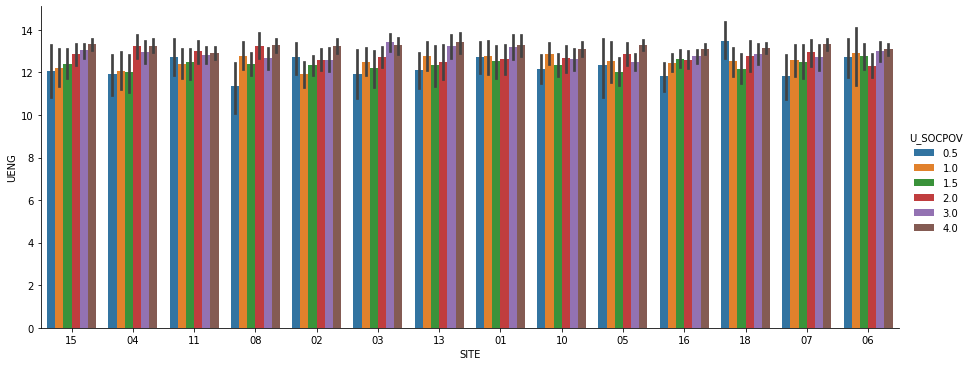

In [9]:
sns.catplot(x='SITE', y='UENG', hue='U_SOCPOV', kind='bar', data=fc2, height=5, aspect=2.5)

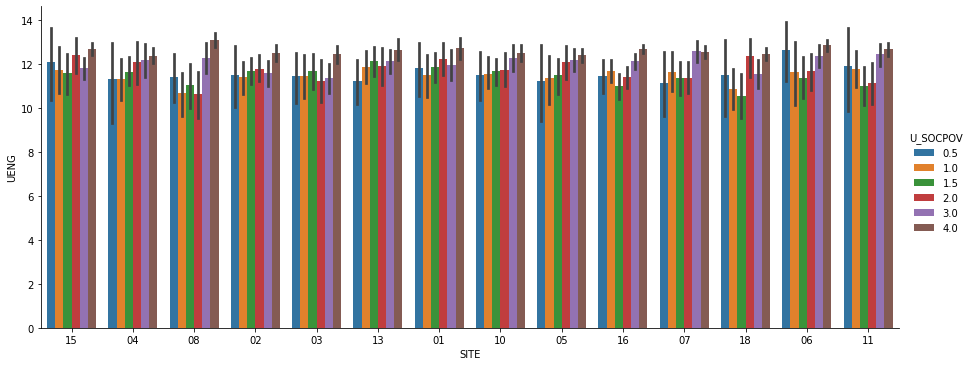

In [10]:
sns.catplot(x='SITE', y='UENG', hue='U_SOCPOV', kind='bar', data=fc3, height=5, aspect=2.5)

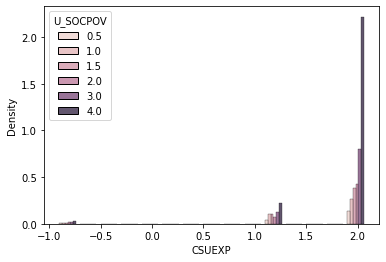

In [11]:
sns.histplot(x='CSUEXP', hue='U_SOCPOV', multiple='dodge', shrink=.8, stat='density', data=fc3)

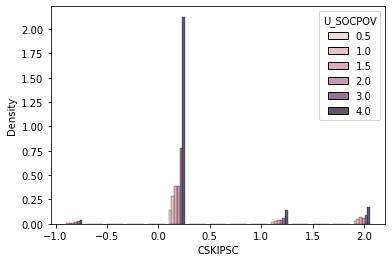

In [12]:
sns.histplot(x='CSKIPSC', hue='U_SOCPOV', multiple='dodge', shrink=.8, stat='density', data=fc3)

## Propensity score attempt

In [13]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

outcome = 'UENGNEG'
predictors = ['KAPPMED','MPUBHOUS']
df_noNull = child.loc[(child[outcome] != -1) & (child[predictors].isin([-1]).any(axis=1)==False)]
glm = sm.GLM(df_noNull[outcome].values, df_noNull[predictors].replace(2,0).values, family=sm.families.Poisson())
res = glm.fit()
res.summary()

reg = RandomForestRegressor()
X = df_noNull[predictors].replace(2,0).values.reshape(1,-1)
y = df_noNull[outcome].values.reshape(1,-1)
reg.fit(X, y)
reg.predict(X)-y #=array(0) si le RFR a marché


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [14]:
df_noNull.shape

(279, 62)

In [15]:
oh = ['KAPPMED','MPUBHOUS']
child[oh].head(15)

,KAPPMED,MPUBHOUS
0,-1,-1
1,1,-1
2,-1,2
3,-1,2
4,-1,1
5,-1,2
6,-1,2
7,-1,2
8,-1,2
9,2,1


In [16]:
#sns.pairplot(child[income+programs+income_hh+housing_hh+programs_hh+education])

In [17]:
#sns.pairplot(child[income+income_hh+housing_hh+education])

In [18]:
#sns.pairplot(child[housing_hh+education])

In [19]:
# Linear regression model for behavior of children

# Features columns

# Declares the model
mod = smf.ols(formula='UBPIA ~ OVERCROWDING+C(GHMAD)+GSELFHR+UMHIGDEG+U_SOCPOV', data=fc2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     100.4
Date:                Wed, 02 Dec 2020   Prob (F-statistic):          1.86e-123
Time:                        18:15:32   Log-Likelihood:                -28404.
No. Observations:               10925   AIC:                         5.682e+04
Df Residuals:                   10918   BIC:                         5.687e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.7279      0.130     97.661

In [24]:
reg2 = smf.ols(formula='UBPIA ~OVERCROWDING + GSELFHR + U_SOCPOV', data=fc2)
res2 = reg2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     199.3
Date:                Wed, 02 Dec 2020   Prob (F-statistic):          7.94e-126
Time:                        18:27:04   Log-Likelihood:                -28406.
No. Observations:               10925   AIC:                         5.682e+04
Df Residuals:                   10921   BIC:                         5.685e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       12.7714      0.120    106.201   

## Education

In [36]:
outcome = 'UENG'
predictors = family+income+housing_hh
df_noNull2 = fc2.loc[(fc2[outcome] != -1) & (fc2[predictors].isin([-1]).any(axis=1)==False)]
df_noNull2.shape

(1099, 62)

In [38]:
# Declares the model
mod = smf.ols(formula='UENG ~ GSELFHR+UFAMSTR+UMH2+UMHIGDEG+U_SOCPOV+MNBEDRMS+MOWNRENT+OVERCROWDING', data=df_noNull2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     9.584
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           6.82e-13
Time:                        19:05:50   Log-Likelihood:                -2577.3
No. Observations:                1099   AIC:                             5173.
Df Residuals:                    1090   BIC:                             5218.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.2790      0.765     13.443   

In [42]:
# Keep only significant variables
mod = smf.ols(formula='UENG ~ UFAMSTR+UMH2+MNBEDRMS+OVERCROWDING', data=df_noNull2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     17.71
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           4.23e-14
Time:                        19:10:53   Log-Likelihood:                -2580.1
No. Observations:                1099   AIC:                             5170.
Df Residuals:                    1094   BIC:                             5195.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.7455      0.627     17.126   

## Health

In [43]:
outcome = 'BHLTHN'
predictors = family+income+housing_hh
df_noNull2 = fc2.loc[(fc2[outcome] != -1) & (fc2[predictors].isin([-1]).any(axis=1)==False)]
df_noNull2.shape

(1104, 62)

In [44]:
# Declares the model
mod = smf.ols(formula='BHLTHN ~ GSELFHR+UFAMSTR+UMH2+UMHIGDEG+U_SOCPOV+MNBEDRMS+MOWNRENT+OVERCROWDING', data=df_noNull2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     14.92
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           6.82e-21
Time:                        19:13:44   Log-Likelihood:                -1386.5
No. Observations:                1104   AIC:                             2791.
Df Residuals:                    1095   BIC:                             2836.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.0843      0.257     11.995   

In [46]:
# Significant variables
mod = smf.ols(formula='BHLTHN ~ UFAMSTR+UMH2+U_SOCPOV+OVERCROWDING', data=df_noNull2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     28.36
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           1.91e-22
Time:                        19:15:10   Log-Likelihood:                -1389.4
No. Observations:                1104   AIC:                             2789.
Df Residuals:                    1099   BIC:                             2814.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.9914      0.181     16.519   

## Mental health


**fc2**


In [47]:
outcome = 'UBPIA'
predictors = family+income+housing_hh
df_noNull2 = fc2.loc[(fc2[outcome] != -1) & (fc2[predictors].isin([-1]).any(axis=1)==False)]
df_noNull2.shape

(1102, 62)

In [49]:
# Declares the model
mod = smf.ols(formula='UBPIA ~ GSELFHR+UFAMSTR+UMH2+UMHIGDEG+U_SOCPOV+MNBEDRMS+MOWNRENT+OVERCROWDING', data=df_noNull2)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     20.48
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           4.40e-29
Time:                        19:20:43   Log-Likelihood:                -2358.7
No. Observations:                1102   AIC:                             4735.
Df Residuals:                    1093   BIC:                             4780.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.9397      0.623     17.566   

In [50]:
# Significant variables
mod = smf.ols(formula='UBPIA ~ UFAMSTR+UMH2+MNBEDRMS+MOWNRENT', data=df_noNull2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     39.57
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           5.48e-31
Time:                        19:22:35   Log-Likelihood:                -2361.4
No. Observations:                1102   AIC:                             4733.
Df Residuals:                    1097   BIC:                             4758.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4056      0.534     19.495      0.0

In [51]:
# Significant variables
mod = smf.ols(formula='UBPIA ~ UFAMSTR+UMH2+MOWNRENT', data=df_noNull2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     51.94
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           2.15e-31
Time:                        19:22:54   Log-Likelihood:                -2362.5
No. Observations:                1102   AIC:                             4733.
Df Residuals:                    1098   BIC:                             4753.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0838      0.490     20.588      0.0

**fc3**

In [52]:
outcome = 'UBPIB'
predictors = family+income+housing_hh
df_noNull3 = fc3.loc[(fc3[outcome] != -1) & (fc3[predictors].isin([-1]).any(axis=1)==False)]
df_noNull3.shape

(700, 62)

In [54]:
# Declares the model
mod = smf.ols(formula='UBPIB ~ GSELFHR+UFAMSTR+UMH2+UMHIGDEG+U_SOCPOV+MNBEDRMS+MOWNRENT+OVERCROWDING', data=df_noNull3)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIB   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     13.13
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           9.94e-18
Time:                        19:25:19   Log-Likelihood:                -1477.5
No. Observations:                 700   AIC:                             2973.
Df Residuals:                     691   BIC:                             3014.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.5808      0.746     15.516   

In [55]:
# Significant
mod = smf.ols(formula='UBPIB ~ UFAMSTR+UMH2', data=df_noNull3)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIB   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     49.82
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           5.98e-21
Time:                        19:27:24   Log-Likelihood:                -1480.2
No. Observations:                 700   AIC:                             2966.
Df Residuals:                     697   BIC:                             2980.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.0825      0.479     23.144      0.0

## Conclusion Q1

Looking at the whole model, we can say that mental health is most influenced by housing conditions.

## Mental health of UMH2

In [56]:
outcome = 'UMH2'
predictors = family_hh+income+housing_hh
df_noNull = child.loc[(child[outcome] != -1) & (child[predictors].isin([-1]).any(axis=1)==False)]
df_noNull.shape

(33598, 62)

In [57]:
# Declares the model
mod = smf.ols(formula='UMH2 ~ CHLD0_5+CHLD6_17+UHHCOUNT+U_SOCPOV+MNBEDRMS+MOWNRENT+OVERCROWDING', data=df_noNull)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     235.1
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:44:21   Log-Likelihood:            -1.3367e+05
No. Observations:               33598   AIC:                         2.673e+05
Df Residuals:                   33590   BIC:                         2.674e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       72.5018      0.579    125.136   

In [58]:
# Significant
mod = smf.ols(formula='UMH2 ~ CHLD0_5+CHLD6_17+U_SOCPOV+MNBEDRMS+MOWNRENT', data=df_noNull)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     328.3
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:45:30   Log-Likelihood:            -1.3367e+05
No. Observations:               33598   AIC:                         2.673e+05
Df Residuals:                   33592   BIC:                         2.674e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.9315      0.460    158.662      0.0

In [59]:
# Significant
mod = smf.ols(formula='UMH2 ~ CHLD0_5+U_SOCPOV+MNBEDRMS+MOWNRENT', data=df_noNull)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     410.3
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:46:01   Log-Likelihood:            -1.3367e+05
No. Observations:               33598   AIC:                         2.673e+05
Df Residuals:                   33593   BIC:                         2.674e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.8818      0.449    162.442      0.0